In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import spacy
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix

nlp = spacy.load('es', vectors=False, entity=False)

In [ ]:
def limpieza(linea):
    """ Sólo se dejan los tokens que son palabras y números"""
    
    newline = []
    for tok in linea:
        if str(tok).isalpha() or str(tok).isdigit() or str(tok)=='.':
            newline.append(tok)
                
    return newline


def get_conll(oraciones):
    """Toma como entrada una lista de listas, donde cada lista es una oración con palabras procesadas con spacy."""
    # lista de palabras, lemmas, categorías sintácticas y dependencias
    toks = []
    toks_lemma = []
    toks_pos = []
    toks_dep = []
    toks_head = []
    
    for sent in oraciones:
        for word in sent:
            toks.append(word)
            toks_lemma.append(word.lemma_)
            toks_pos.append(word.pos_)
            toks_dep.append(word.dep_)
            toks_head.append(word.head.lemma_)
    
    """Se terminan de limpiar los tokens (Tener en cuenta que se van a usar los lemas)
    * Todo se pasa a minúscula
    * Los números se pasan a dígito"""
    lemas = []
    for w in toks_lemma:
        if w.isdigit():
            lemas.append('dígito')
        else :
            lemas.append(w.lower())
    
    conll = pd.DataFrame({'Word':toks , 'Lemma':lemas , 'Pos':toks_pos , 'Dep':toks_dep, 'HeadDep':toks_head })
    return conll


def load_data():
    """Carga una parte distinta del corpus."""
    with open('./spanishText_480000_485000', "r", encoding="utf8", errors='ignore') as file:
        while True:
            texto = ''
            for n in range(0,15000):
                texto += file.readline()
            if not texto:
                break # se cargó todo el texto
            yield texto

load = load_data()
load.__next__


In [ ]:
Conll = pd.DataFrame(columns=['Word','Lemma','Pos','Dep'])

for i in range(0,5):
    texto = next(load)
    
    doc = nlp(texto)
    # Separo en oraciones. lista de strings
    oraciones = [sent for sent in doc.sents]
    # Limpio las oraciones. lista de tokens. cada lista es una oración.
    oraciones = [limpieza(sent) for sent in oraciones]
    # Se eliminan las oraciones con menos de 5 tokens
    oraciones = [sent for sent in oraciones if len(sent)>4]
    
    wanalysis = get_conll(oraciones)
    Conll = pd.concat([Conll, wanalysis], sort=False)

### Graficamos el conteo de palabras



In [ ]:
import collections

lemas = list(Conll.Lemma)
frecs = collections.Counter(lemas)

In [ ]:
Conteo = pd.DataFrame.from_dict(dict(frecs), orient='index')
Conteo = Conteo.sort_values(by=0, ascending=False)
Conteo = Conteo.reset_index().rename(columns={'index':'Palabras', 0:'Frecuencias'})

In [ ]:
plt.figure(figsize=(10,5))

sns.lineplot(data=Conteo, x=np.array(Conteo.index), y='Frecuencias')
plt.ylabel('Frecuencia de palabras')
plt.xlabel('Índices de palabras')
plt.ylim(0, Conteo.Frecuencias.max())
sns.despine()
plt.savefig("Conteo de Palabras.jpg")

__Se eliminan las palabras con poca frecuencia (ruido) y las stop words.__

In [ ]:
# Se marcan las palabras con una frecuencia menor a 50
ruido = list(Conteo[Conteo.Frecuencias<50]['Palabras'])

In [ ]:
# STOP WORDS
stopspanish = stopwords.words('spanish')

In [ ]:
# uso el cuerpo de lemas, eliminando las palabras que no aparecen suficientes veces y stopwords
corpus_clean = [w for w in lemas if not (w in ruido or w in stopspanish)] 

In [ ]:
import pickle

def guardar_corpus(datos):
    with open("corpus_cleanTriplas.pkl", "wb") as f:
        pickle.dump(datos, f)
        
guardar_corpus(corpus_clean)

In [ ]:
def cargar_corpus():
     with open("corpus_cleanTriplas.pkl", "rb") as f:
        return pickle.load(f)
      
corpus_clean = cargar_corpus()

### Diccionario con co-ocurrencias de palabras y Matriz de co-ocurrencias

In [ ]:
corpus_clean = ' '.join(corpus_clean) # un texto en un string
sent = [i.strip(' .') for i in sent_tokenize(corpus_clean, language='spanish') if len(word_tokenize(i))>2]

In [ ]:
def dict_cooc_gen(sentences,w):
    """Toma como entrada una lista de strings, cada string es una oración.
        Devuelve una lista de diccionarios con las coocurrencias y una lista de palabras para los indices de la matriz. 
        Ventana tamaño variable. (w palabras a izq y w palabras a der)"""
    
    cooc = [] # lista de diccionarios
    idx = [] # lista de palabras
    for sen in sentences:
        sent = list(word_tokenize(sen, language='spanish'))
        for m,tok in enumerate(sent):
            
            vecinos = []
            # vecinos a la derecha
            for l in range(1,w+1):
                if m+l > len(sent)-1:
                    break
                else:
                    vecinos.append(sent[m+l])
            # vecinos a la izquierda
            for l in range(1,w+1):
                if m-l < 0:
                    break
                else:
                    vecinos.append(sent[m-l])
            
            
            # para agregar los vecinos de una nueva palabra
            if tok in idx:
                i = idx.index(tok)
                cooc[i][tok] +=1
            else :
                cooc.append({tok:1}) 
                idx.append(tok)
                i = idx.index(tok)

            for v in vecinos:
                if not v in cooc[i]:
                    cooc[i][v] =1
                else:
                    cooc[i][v] +=1
                        

    return cooc, idx

In [ ]:
coocurrencias, idx = dict_cooc_gen(sent,2)

__Agrego la morfología de la palabra. Ésto sirve para una categorización más sintáctica__

In [ ]:
def dict_cooc_pos(coocurrencias, conll):  
    posdicts= {}
    for id in range(0,len(conll)):
        if not conll.iloc[id,:].Lemma in list(posdicts.keys()):
            posdicts[conll.iloc[id,:].Lemma] = [conll.iloc[id,:].Pos]
        else:
            posdicts[conll.iloc[id,:].Lemma].append(conll.iloc[id,:].Pos)
            
    for key,value in posdicts.items():
        if key in idx:
            i = idx.index(key)
            for pos in value:
                if not pos in list(coocurrencias[i].keys()):
                    coocurrencias[i][pos]=1
                else:
                    coocurrencias[i][pos]+=1
    
    return coocurrencias

In [ ]:
coocurrencias = dict_cooc_pos(coocurrencias, Conll)

In [ ]:
def dict_cooc_triplas(coocurrencias, conll):
    triplasdict = {}
    for id in range(0,len(conll)):
        if not conll.iloc[id,:].Lemma in list(triplasdict.keys()):
            triplasdict[conll.iloc[id,:].Lemma] = [conll.iloc[id,:].Dep + '_' + conll.iloc[id,:].HeadDep]
        else:
            triplasdict[conll.iloc[id,:].Lemma].append(conll.iloc[id,:].Dep + '_' + conll.iloc[id,:].HeadDep)
            
    for key,value in triplasdict.items():
        if key in idx:
            i = idx.index(key)
            for dep in value:
                if not dep in list(coocurrencias[i].keys()):
                    coocurrencias[i][dep]=1
                else:
                    coocurrencias[i][dep]+=1
                    
    return coocurrencias

In [ ]:
coocurrencias = dict_cooc_triplas(coocurrencias, Conll)

In [ ]:
# Se obtiene la matriz de coocurrencias
vectorizer = DictVectorizer()
vec = vectorizer.fit_transform(coocurrencias)
# Se muestra en un dataframe
columnas=vectorizer.get_feature_names()
matriz = pd.DataFrame(vec.toarray(), columns=columnas)
matriz = matriz.set_axis(idx,axis=0, inplace=False)


In [ ]:
def guardar_mat(datos):
    with open("mattriplascooc.pkl", "wb") as f:
        pickle.dump(datos, f)


def cargar_mat():
     with open("mattriplascooc.pkl", "rb") as f:
        return pickle.load(f)

guardar_mat(matriz)

In [ ]:
matriz = cargar_mat()


### LSA para reducir dimensionalidad

With SVD(Singular value decomposition) to this matrix to reduce the number of features from ~10000 to around 100 to 300 features which will condense all the important features into small vector space.

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=300, n_iter=8, random_state=123)
matriz_reducida = svd.fit_transform(matriz.values) 

In [ ]:
var = svd.explained_variance_ratio_.sum()
print('La varianza conservada es: ', var)

In [ ]:
matred = pd.DataFrame(matriz_reducida, index=matriz.index )

In [ ]:
def guardar_lsa(datos):
    with open("lsa00.pkl", "wb") as f:
        pickle.dump(datos, f)

guardar_lsa(matred)

In [20]:
def cargar_lsa():
     with open("lsa00.pkl", "rb") as f:
        return pickle.load(f)

matred = cargar_lsa()
matriz_reducida = matred.values

### t-sne para Visualizar

In [21]:
from sklearn.manifold import TSNE

In [23]:
viz = TSNE(n_components=2, metric='cosine', init='pca', random_state=123)
t_sne = viz.fit_transform(matriz_reducida)

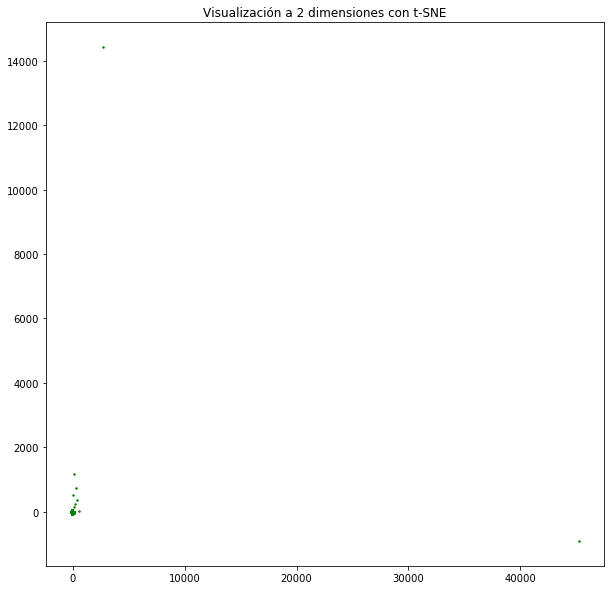

<Figure size 432x288 with 0 Axes>

In [33]:
plt.figure(figsize=(10,10)) 

plt.scatter(t_sne[:, 0], t_sne[:, 1], s=2, c='g')
plt.title("Visualización a 2 dimensiones con t-SNE")
plt.axis('tight')
plt.show()
plt.savefig("t-sne.jpg")

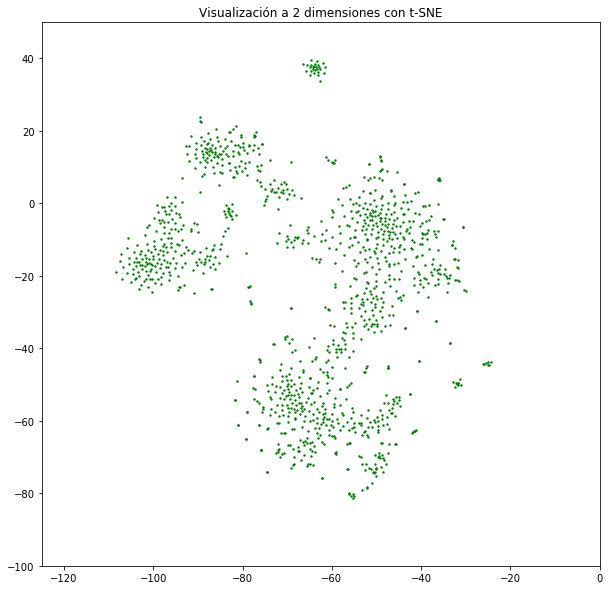

<Figure size 432x288 with 0 Axes>

In [34]:
plt.figure(figsize=(10,10)) 

plt.scatter(t_sne[:, 0], t_sne[:, 1], s=2, c='g')
plt.title("Visualización a 2 dimensiones con t-SNE")
plt.axis([-125,0,-100,50])

plt.show()
plt.savefig("t-sne_zoom.jpg")

### Clustering con Kmeans de NLTK

In [ ]:
from nltk.cluster import KMeansClusterer, cosine_distance  # euclidean_distance

In [ ]:
clusterer = KMeansClusterer(10, cosine_distance, avoid_empty_clusters=True)
labels = clusterer.cluster(matriz_reducida, True)

labels_unique = np.unique(labels)
n_clusters = len(labels_unique)

print('Número de clusters encontrados: ', n_clusters)
clusters = pd.DataFrame({'Palabras':matred.index, 'Etiqueta':labels})

clusters.to_csv('10clusters.csv')

In [ ]:
clusterer = KMeansClusterer(50, cosine_distance, avoid_empty_clusters=True)
labels = clusterer.cluster(matriz_reducida, True)

labels_unique = np.unique(labels)
n_clusters = len(labels_unique)

print('Número de clusters encontrados: ', n_clusters)
clusters = pd.DataFrame({'Palabras':matred.index, 'Etiqueta':labels})

clusters.to_csv('50clusters.csv')

In [ ]:
clusterer = KMeansClusterer(100, cosine_distance, avoid_empty_clusters=True)
labels = clusterer.cluster(matriz_reducida, True)

labels_unique = np.unique(labels)
n_clusters = len(labels_unique)

print('Número de clusters encontrados: ', n_clusters)
clusters = pd.DataFrame({'Palabras':matred.index, 'Etiqueta':labels})

clusters.to_csv('100clusters.csv')

### Explorando los clusters:

In [4]:
clust10 = pd.read_csv('10clusters.csv').drop(['Unnamed: 0'], axis=1)

In [6]:
clust10.groupby('Etiqueta').count()

,Palabras
Etiqueta,
0,349
1,6
2,7
3,38
4,32
5,110
6,11
7,175
8,329


In [8]:
for i in range(0,10):
    print('Cluster ', i, ': ', list(clust10[clust10.Etiqueta==i].Palabras),'\n')

Cluster  0 :  ['futbolista', 'jugar', 'delantero', 'consecuencia', 'familia', 'mano', 'embargar', 'mesar', 'equipar', 'nombrar', 'gol', 'debut', 'actor', 'esposo', 'tierra', 'episodio', 'casar', 'profesor', 'teora', 'tiempo', 'cuadrar', 'piano', 'cantante', 'artista', 'revistar', 'trabajar', 'director', 'hijo', 'vez', 'grupo', 'miembro', 'partir', 'accin', 'derecho', 'fecho', 'particular', 'frente', 'ciudad', 'girar', 'comandante', 'principio', 'actividad', 'luchar', 'autor', 'libro', 'municipio', 'trabajo', 'lado', 'valor', 'pesar', 'sangrar', 'muerte', 'control', 'poner', 'territorio', 'ayudar', 'vida', 'frontero', 'objetivar', 'atacar', 'orden', 'edad', 'firmar', 'momento', 'carrera', 'calidad', 'acordar', 'cambiar', 'equipo', 'arte', 'imgenes', 'seriar', 'actriz', 'hermano', 'pelcula', 'lbum', 'disco', 'compositor', 'canción', 'basar', 'texto', 'cine', 'centrar', 'mediar', 'padre', 'noche', 'visitar', 'vestir', 'mundo', 'campar', 'principiar', 'siglo', 'largar', 'final', 'cursar', 

In [11]:
clust50 = pd.read_csv('50clusters.csv').drop(['Unnamed: 0'], axis=1)

In [12]:
clust50.groupby('Etiqueta').count()

,Palabras
Etiqueta,
0,259
1,13
2,1
3,1
4,40
5,30
6,4
7,1
8,31


In [14]:
for i in range(0,50):
    print('Cluster ', i, ': ', list(clust50[clust50.Etiqueta==i].Palabras),'\n')

Cluster  0 :  ['alemania', 'fc', 'despus', 'san', 'luis', 'unidos', 'all', 'universidad', 'pas', 'francia', 'alemn', 'seleccin', 'mundial', 'mara', 'lpez', 'garca', 'eduardo', 'manuel', 'fernando', 'carlos', 'francs', 'pars', 'trmino', 'francisco', 'estudi', 'msica', 'festival', 'roma', 'gobierno', 'graham', 'londres', 'ii', 'du', 'franco', 'poltico', 'participacin', 'gobernar', 'repblica', 'recibi', 'partido', 'adems', 'fundacin', 'comisin', 'cmara', 'form', 'economa', 'congreso', 'investigacin', 'transicin', 'argentina', 'justicia', 'iii', 'liga', 'ligar', 'v', 'ejrcito', 'gonzlez', 'barcelona', 'inici', 'particip', 'juan', 'divisin', 'washington', 'c', 'internet', 'pblico', 'estacin', 'naci', 'cancin', 'river', 'school', 'opera', 'santa', 'fe', 'ltima', 'william', 'segunda', 'jos', 'irn', 'regin', 'europa', 'don', 'lder', 'primera', 'religin', 'george', 'continuacin', 'qu', 'ningn', 'peter', 'jorge', 'vase', 'edicin', 'david', 'asia', 'university', 'jess', 'venezuela', 'unin', 'pbli

Cluster  31 :  ['slo', 'luchar', 'ayudar', 'atacar', 'basar', 'visitar', 'vestir', 'ingresar', 'resultar', 'viajar', 'formar', 'registrar', 'mandar', 'avanzar', 'sentir', 'librar', 'cubrir', 'apoyar', 'desarrollar', 'figurar', 'encargar', 'estudiar', 'funcionar', 'marcar'] 

Cluster  32 :  ['escuela', 'grupo', 'vida', 'mujer', 'hombre', 'movimiento'] 

Cluster  33 :  ['saint', 'john', 'poblacin', 'cantn', 'tarn'] 

Cluster  34 :  ['of', 'history', 'catalogue', 'life', 'encyclopedia'] 

Cluster  35 :  ['aparecer'] 

Cluster  36 :  ['seriar'] 

Cluster  37 :  ['cambiar'] 

Cluster  38 :  ['comenz', 'entonces', 'actualmente', 'dentro', 'cercar', 'luego', 'rpidamente', 'tardar', 'alrededor', 'nunca', 'bien', 'finalmente', 'incluso', 'siempre', 'aproximadamente', 'menos', 'ahora', 'pronto', 'tan', 'casi', 'hoy', 'originalmente', 'posteriormente', 'principalmente', 'especialmente', 'generalmente'] 

Cluster  39 :  ['diez', 'do', 'siete', 'tres', 'seis', 'ambos', 'mil', 'cincar', 'cuatro'] 



In [15]:
clust100 = pd.read_csv('100clusters.csv').drop(['Unnamed: 0'], axis=1)

In [16]:
clust100.groupby('Etiqueta').count()

,Palabras
Etiqueta,
0,12
1,3
2,1
3,72
4,2
...,...
95,3
96,1
97,2


In [17]:
for i in range(0,100):
    print('Cluster ', i, ': ', list(clust100[clust100.Etiqueta==i].Palabras),'\n')

Cluster  0 :  ['varios', 'cada', 'vario', 'cualquiera', 'alguno', 'aquel', 'diverso', 'diferente', 'talar', 'distinto', 'ninguno', 'cierto'] 

Cluster  1 :  ['pgina', 'sitio', 'web'] 

Cluster  2 :  ['milisegundo'] 

Cluster  3 :  ['paz', 'teora', 'accin', 'secretario', 'comandante', 'ministro', 'ley', 'cmo', 'seguridad', 'xito', 'orden', 'arte', 'hotel', 'rus', 'mar', 'costa', 'noroeste', 'lago', 'noreste', 'reinar', 'nios', 'fuerza', 'jefe', 'independencia', 'cultura', 'segundo', 'travs', 'coronel', 'plan', 'historia', 'ttulo', 'maestro', 'presidencia', 'hospital', 'artculos', 'puente', 'pelculas', 'teatro', 'salud', 'video', 'literatura', 'oficina', 'categora', 'pueblo', 'madre', 'produccin', 'radiar', 'comunidad', 'gobernador', 'colonia', 'serie', 'ciencia', 'biblioteca', 'arquitectura', 'sociedad', 'pilar', 'parque', 'rock', 'obispo', 'captulo', 'plaza', 'calle', 'memoria', 'castillo', 'co', 'metal', 'parroquia', 'anlisis', 'merindad', 'cerro', 'aeropuerto', 'capilla'] 

Cluster  

Cluster  75 :  ['delantero', 'cuadrar', 'externo', 'particular', 'joven', 'polticas', 'relacionar', 'griego', 'basar', 'pequea', 'cristiano', 'responsable', 'izquierdo', 'enemigo', 'herir', 'cortar', 'ganador', 'poltica', 'medio', 'caractersticas', 'ltimos', 'destinar', 'sencillo', 'pequeo', 'lateral', 'solar', 'futuro', 'vecino', 'marcar', 'plano', 'exterior', 'guerrillero', 'sillar'] 

Cluster  76 :  ['luis', 'mara', 'garca', 'manuel', 'carlos', 'juan', 'jos', 'antonio', 'snchez', 'rodrguez'] 

Cluster  77 :  ['embargar', 'nombrar', 'actor', 'casar', 'hijo', 'miembro', 'municipio', 'cine', 'padre', 'personar', 'mujer', 'hogar', 'papel', 'movimiento', 'promediar', 'clase', 'programar', 'honor'] 

Cluster  78 :  ['espaa'] 

Cluster  79 :  ['futbolista', 'debut', 'amor', 'episodio', 'fecho', 'principio', 'pesar', 'muerte', 'edad', 'actriz', 'pelcula', 'noche', 'largar', 'habitante', 'estudiante', 'victoria', 'regimentar', 'comandar', 'librar', 'pie', 'favor', 'estrellar', 'ciclista', 'p